<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

TOTAL_FRAMES=50
random.seed(20)

# Some functions to plot our points and draw the lines
def plot_points(features, labels, ax=None):
  X = np.array(features)
  y = np.array(labels)
  spam = X[np.argwhere(y==1)]
  ham = X[np.argwhere(y==0)]
  if ax is None:
    p=plt
    p.xlabel('ha')
    p.ylabel('boo')
  else:
    p=ax
    p.set_xlabel('ha')
    p.set_ylabel('boo')
  p.scatter([s[0][0] for s in spam],
            [s[0][1] for s in spam],
            s = 100,
            color = 'cyan',
            edgecolor = 'k',
            marker = '^')
  p.scatter([s[0][0] for s in ham],
            [s[0][1] for s in ham],
            s = 100,
            color = 'red',
            edgecolor = 'k',
            marker = 's')
  p.legend(['happy','sad'])

def draw_line(a,b,c, starting=0, ending=3, **kwargs):
  # Plotting the line ax + by + c = 0
  x = np.linspace(starting, ending, 1000)
  plt.plot(x, -c/b - a*x/b, **kwargs)

# Classification

Regression models predict a number; whereas *classification* models predict a state or a category (drawing a line to separate our data points).

*Perceptron* uses linear regression and is building block of neuro net.

Instead of expressing a line with $y=mx+b$, we rewrite it into $w_1x_1+w_2x_2+b=0$
The line divides the plane into two zones with LHS>=0 being the positive zone, LHS<0 the negative zone.

If we want to flip the positive and negative zones, simplly change the sign of all the w and b in the equation.

Step function (a specific case of activation function):
* $step(x)=1 \text{ if } x\ge 0 $
* $step(x)=0 \text{ if } x\lt 0 $

The perceptron can be expressed with step function - the perceptron produces 1 if point is in positive zone; 0 if in negative zone:
$$\hat{y}=step(w_1x_1+w_2x_2+b)$$

The bias / intercept term basically gives the result for when w's are 0. i.e. in the alien sentiment example, it's the sentiment of a quiet alien (no words are said).

## Error function

Intuitively, we can sum up the distance of wrongly classified points and the dividing line. But this is not used because it's complicated to calculate the distance: the square root has complicated derivative.

So instead we use a *score* with these properties:
1. points on boundary, score=0
2. points in +zone, score>0
3. points in -zone, score<0
4. points close to boundary, |score| is small
5. points far from boundary, |score| is large

The *perceptron error* should be proportional to the distance between point and boundary. The perceptron for a point is defined as:
1. if point is correctly classified, error=0
2. if point is misclassified, $\text{error}=|w_1x_1+w_2x_2+\ldots+w_nx_n+b|=| w\cdotp x + b |=|\text{score}|$

The derivitives of the error:
* $\frac{\delta \text{error}}{\delta w}=x$
* $\frac{\delta \text{error}}{\delta b}=1$

The *mean perceptron error* (i.e. the error for entire dataset) = average of perceptron errors of all points.

## Perceptron Algorithm

Using the happy/sad alien as an example. They have two words (Ha, Boo) in their vocab (i.e. features is 2-dim).

   Ha  Boo  Happy(1)/Sad(0)
0   1    0                0
1   0    2                0
2   1    1                0
3   1    2                0
4   1    3                1
5   2    2                1
6   2    3                1
7   3    2                1


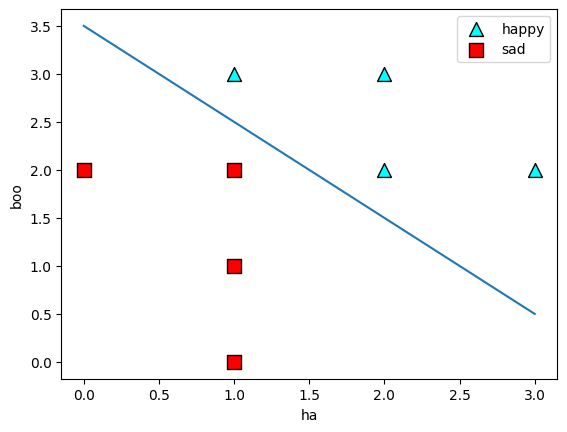

In [13]:
# we have 8 data points and their labels in the dataset
batch_features = np.array([[1,0],[0,2],[1,1],[1,2],[1,3],[2,2],[2,3],[3,2]])
labels = np.array([0,0,0,0,1,1,1,1])

# printing the dataset in table
df = pd.DataFrame({
    'Ha' : batch_features[:,0],
    'Boo' : batch_features[:,1],
    'Happy(1)/Sad(0)': labels
})
print(df)

# Plotting the points
plot_points(batch_features, labels)

# Uncomment the following line to see a good line fit for this data.
draw_line(1,1,-3.5)

In [132]:
#############
# m=batch size, n=vocab dim (num of words)
# weights: dim (n,)
# bias: scalar
# features: (n,)
# label: scalar
# batch_features: (m, n)
# labels: (m)
#############
def step(x):
  return 1 if x>=0 else 0

def score(weights, bias, features):
  return np.dot(features, weights) + bias

def prediction(weights, bias, features):
  return step(score(weights, bias, features))

def error(weights, bias, features, label):
  pred = prediction(weights, bias, features)
  if pred == label:
    return 0
  else:
    return np.abs(score(weights, bias, features))

def mean_perceptron_error(weights, bias, batch_features, labels):
  total_error = 0
  batch_size = len(batch_features) # number of points in the dataset
  for i in range(batch_size):
    total_error += error(weights, bias, batch_features[i], labels[i])

  return total_error / batch_size

# the back prop
def perceptron_trick(weights, bias, features, label, learning_rate = 0.01):
  pred = prediction(weights, bias, features)
  delta = (label-pred) * learning_rate
  n = len(weights)
  for i in range(n):
    weights[i] += delta * features[i]
  bias += delta
  return weights, bias

def perceptron_algorithm(batch_features, labels, learning_rate = 0.01, epochs=200):
  m = len(batch_features)
  n = len(batch_features[0])
  weights = [random.random() for i in range(n)]
  bias = random.random()
  Ws, bs, errs = [None] * epochs, [None] * epochs, [None] * epochs

  for epoch in range(epochs):
    error = mean_perceptron_error(weights, bias, batch_features, labels)

    i = random.randint(0, m-1) # Pick a random point in our dataset
    weights, bias = perceptron_trick(weights, bias, batch_features[i], labels[i])

    # preceptron_trick updates elements of weights list, so it's returning the
    # original list, so here we need to make a copy
    Ws[epoch] = weights.copy()
    bs[epoch] = bias
    errs[epoch]=error

    # print(f"o w={weights}, b={bias}")
    # print(f"x w={Ws[epoch]}, b={bs[epoch]}")

  return Ws, bs, errs

weights=[0.029923152866939858, 0.02595615591041223], bias=-0.10025481851754135
errors: max=1.01106637051034, min=0.0


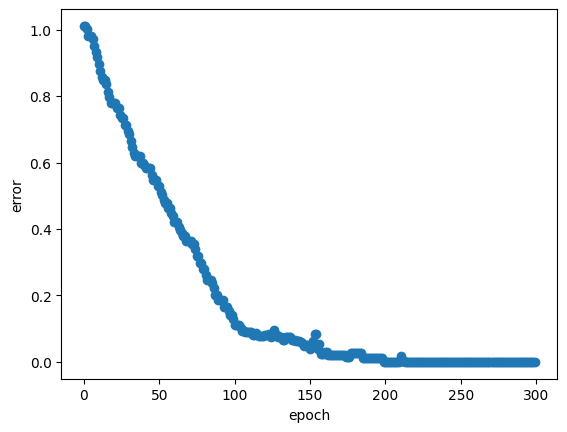

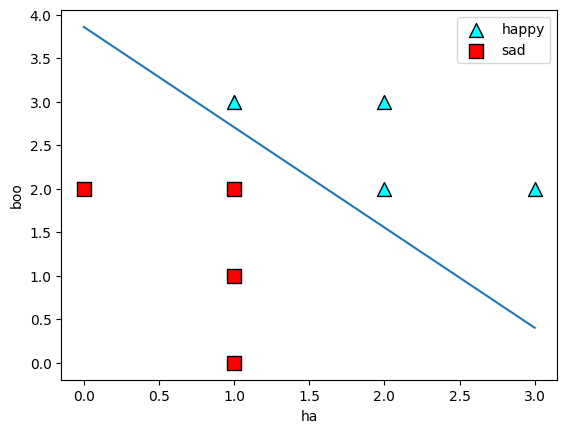

In [136]:
epochs=300
Ws, bs, errs = perceptron_algorithm(batch_features, labels, learning_rate=0.01, epochs=epochs)
w = Ws[-1]
b = bs[-1]

print(f"weights={w}, bias={b}")
print(f"errors: max={max(errs)}, min={min(errs)}")

plt.scatter(np.arange(epochs), errs)
plt.xlabel('epoch')
plt.ylabel('error')
plt.show()

plot_points(batch_features, labels)
# Uncomment the following line to see a good line fit for this data.
draw_line(w[0],w[1],b)

In [44]:
frames = np.linspace(0, epochs, TOTAL_FRAMES, dtype=np.uint32)
frames, len(frames)

(array([     0,   2040,   4081,   6122,   8163,  10204,  12244,  14285,
         16326,  18367,  20408,  22448,  24489,  26530,  28571,  30612,
         32653,  34693,  36734,  38775,  40816,  42857,  44897,  46938,
         48979,  51020,  53061,  55102,  57142,  59183,  61224,  63265,
         65306,  67346,  69387,  71428,  73469,  75510,  77551,  79591,
         81632,  83673,  85714,  87755,  89795,  91836,  93877,  95918,
         97959, 100000], dtype=uint32),
 50)

In [139]:
# frames = np.logspace(0, np.log10(epochs), TOTAL_FRAMES, dtype=np.uint32)
# frames[:2] = 0
# frames, len(frames)
# frames = (epochs-frames)[::-1]

(array([  0,   0,   1,   1,   1,   1,   2,   2,   2,   2,   3,   3,   4,
          4,   5,   5,   6,   7,   8,   9,  10,  11,  12,  14,  16,  18,
         20,  23,  26,  29,  32,  36,  41,  46,  52,  58,  66,  74,  83,
         93, 105, 118, 132, 149, 167, 188, 211, 237, 267, 300],
       dtype=uint32),
 50)

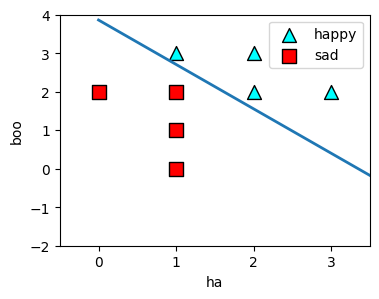

In [147]:
# check the progress of the training
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-2, 4)
plot_points(batch_features, labels, ax=ax)
line, = ax.plot([], [], lw=2)

def init():
  line.set_data([], [])
  return line,

def update(frame):
  idx = min(epochs-1, frames[frame])
  W = Ws[idx]
  b = bs[idx]
  w1, w2 = W[0], W[1]
  x = np.linspace(0, 10, 1000)
  y = -b/w2 - w1*x/w2
  line.set_data(x, y)
  return line,

ani = FuncAnimation(fig, update, frames=TOTAL_FRAMES, init_func=init, blit=True)
HTML(ani.to_jshtml())

## Perceptron using SKLearn

In [166]:
model = Perceptron()
model.fit(batch_features, labels)
model.coef_, model.intercept_

(array([[4., 2.]]), array([-9.]))

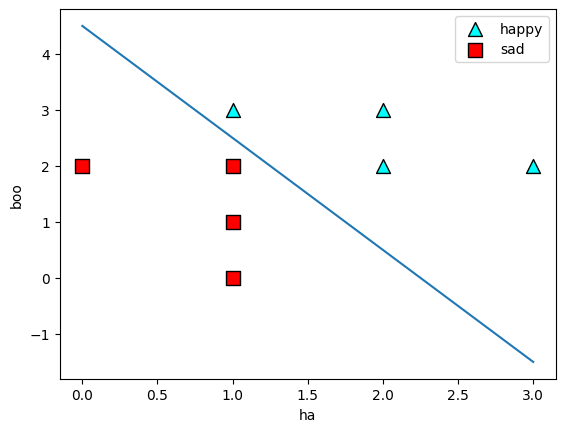

In [167]:
plot_points(batch_features, labels)
draw_line(model.coef_[0,0], model.coef_[0,1], model.intercept_)

# Logistic Perceptron
The previous perceptron returns 1 or 0, they are called *discrete perceptron*. Perceptrons that return continuous values between 0 and 1 are *continuous perceptron*, or commonly called *logistic classifier*.

The output of logistic classifier can be considered a score:
* points with label 0 has score close to 0
* points with label 1 has score close to 1

The algo we use to train the logistic classifiers are called *logistic regression algo*:
$$\hat y=\sigma(w \cdot x + b)
$$

## Error function
1. absolute error - $|y-\hat y|$
2. square error - MAE, MSE, RMSE
3. log loss

1 and 2 are not commonly used for classification; 3 (log loss) is mostly used because it turns multiplication into addition. This is good because multiplication of many small numbers (0,1) become tiny numbers, which is a problem. But log of small number (0,1) just gives negative number, we negate them to make them positive.

Formula for log loss:
1. if label is 0, $\text{log loss} = -\ln(1-\hat y)$
2. if label is 1, $\text{log loss} = -\ln(\hat y)$

Because label y is either 1 or 0, the above can be condensed into: $\text{log loss} = -y\ln(\hat y)-(1-y)\ln(1-\hat y)$
Notice that the above equation is the definition of entropy of base 2: $H(p)=-p\log(p)-(1-p)\log(1-p)$. Therefore, the log loss is the entropy of the predicted probability distribution w.r.t. the true class labels.

The log loss of dataset is sum of log loss of each data point. **Note:** the log loss can never be zero.

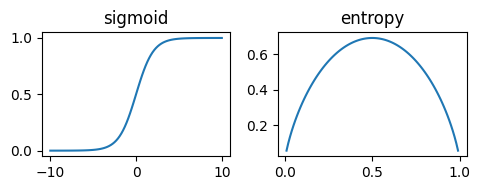

In [56]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def log_loss(y, y_hat):
  return -y*math.log(y_hat)-(1-y)*math.log(1-y_hat)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5,2))
# plot sigmoid
xs = np.linspace(-10, 10, 100)
ax1.plot(xs, [sigmoid(x) for x in xs])
ax1.set_title('sigmoid')
# plot entropy
ps = np.linspace(0,1,100, endpoint=False)
ax2.plot(ps[1:], [log_loss(p,p) for p in ps[1:]])
ax2.set_title('entropy')

plt.tight_layout()
plt.show()

In [12]:
# observe ln(x) behaviour: x->1, ln(x)->0; x->0 and x>0, then -ln(x) is large
-math.log(0.99), -math.log(0.0001)

(0.01005033585350145, 9.210340371976182)

In [57]:
# use the above perceptron of 4x_1+2x_2-9
preds, losses = [], []
for i in range(len(batch_features)):
  features = batch_features[i]
  pred = sigmoid(4 * features[0] + 2 * features[1] -9)
  loss = log_loss(labels[i], pred)

  preds.append(pred)
  losses.append(loss)

# printing the dataset in table
df = pd.DataFrame({
    'Ha' : batch_features[:,0],
    'Boo' : batch_features[:,1],
    'Happy(1)/Sad(0)': labels,
    'prediction' : preds,
    'y-y_hat' : labels - preds,
    'log loss': losses
})
print(df)
print("total loss: ", sum(losses))

   Ha  Boo  Happy(1)/Sad(0)  prediction   y-y_hat  log loss
0   1    0                0    0.006693 -0.006693  0.006715
1   0    2                0    0.006693 -0.006693  0.006715
2   1    1                0    0.047426 -0.047426  0.048587
3   1    2                0    0.268941 -0.268941  0.313262
4   1    3                1    0.731059  0.268941  0.313262
5   2    2                1    0.952574  0.047426  0.048587
6   2    3                1    0.993307  0.006693  0.006715
7   3    2                1    0.999089  0.000911  0.000911
total loss:  0.7447555901050578


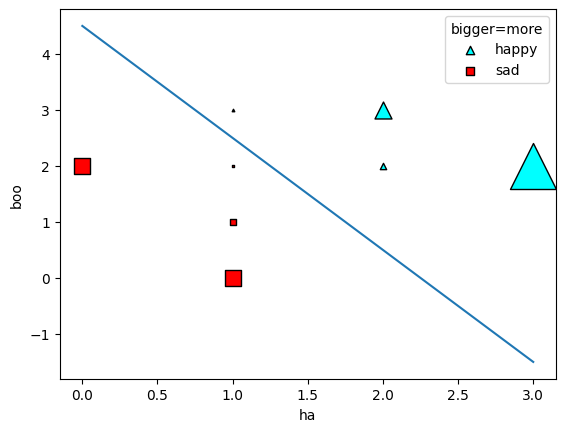

In [58]:
def plot_logistic_points(batch_features, labels, losses, size_scale=1):
  for f, y, loss in zip(batch_features, labels, losses):
    if y==1:
      c='cyan'
      ec='k'
      m='^'
    else:
      c='red'
      ec='k'
      m='s'
    plt.scatter([f[0]], [f[1]], s=(1/loss*size_scale), color=c, edgecolor=ec, marker=m)
  plt.xlabel('ha')
  plt.ylabel('boo')
  handles = [
      plt.scatter([], [], color='cyan', edgecolors='k', marker='^', label='happy'),
      plt.scatter([], [], color='red', edgecolors='k', marker='s', label='sad')
  ]
  plt.legend(handles=handles, title='bigger=more')

plot_logistic_points(batch_features, labels, losses)
draw_line(4,2,-9)
plt.show()

## Logistic Regression Algo

In [59]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def score(weights, bias, features):
  return np.dot(weights, features) + bias

def prediction(weights, bias, features):
  return sigmoid(score(weights, bias, features))

def log_loss(weights, bias, features, label):
  pred = prediction(weights, bias, features)
  return -label*np.log(pred) - (1-label)*np.log(1-pred)

def total_log_loss(weights, bias, batch_features, labels):
  total_error = 0
  for i in range(len(batch_features)):
    total_error += log_loss(weights, bias, batch_features[i], labels[i])
  return total_error

def logistic_trick(weights, bias, features, label, learning_rate = 0.01):
  pred = prediction(weights, bias, features)
  delta = (label-pred)*learning_rate
  for i in range(len(weights)):
    weights[i] += delta*features[i]
    bias += delta
  return weights, bias

def logistic_regression_algorithm(batch_features, labels,
                                  learning_rate = 0.01, epochs = 1000):
  # plot_points(features, labels)
  # weights = [1.0 for i in range(len(features[0]))]
  # bias = 0.0
  # errors = []
  # for i in range(epochs):
  #   errors.append(total_log_loss(weights, bias, features, labels))
  #   j = random.randint(0, len(features)-1)
  #   weights, bias = logistic_trick(weights, bias, features[j], labels[j])
  # return weights, bias
  m = len(batch_features)
  n = len(batch_features[0])
  weights = [1.0 for i in range(n)]
  bias = 0.0
  Ws, bs, errs = [None] * epochs, [None] * epochs, [None] * epochs

  for epoch in range(epochs):
    error = total_log_loss(weights, bias, batch_features, labels)

    i = random.randint(0, m-1) # Pick a random point in our dataset
    weights, bias = logistic_trick(weights, bias, batch_features[i], labels[i])

    # logistic_trick updates elements of weights list, so it's returning the
    # original list, so here we need to make a copy
    Ws[epoch] = weights.copy()
    bs[epoch] = bias
    errs[epoch]=error

  return Ws, bs, errs

weights=[1.4515618963570192, 0.87181391935881], bias=-3.4887372623996376
errors: max=8.665435613991766, min=2.026338931377217
   Ha  Boo  Happy(1)/Sad(0)  prediction   y-y_hat  log loss
0   1    0                0    0.115355 -0.115355  0.122568
1   0    2                0    0.148665 -0.148665  0.160950
2   1    1                0    0.237694 -0.237694  0.271408
3   1    2                0    0.427136 -0.427136  0.557106
4   1    3                1    0.640668  0.359332  0.445243
5   2    2                1    0.760972  0.239028  0.273159
6   2    3                1    0.883893  0.116107  0.123419
7   3    2                1    0.931475  0.068525  0.070986
total loss:  2.0248388450986643


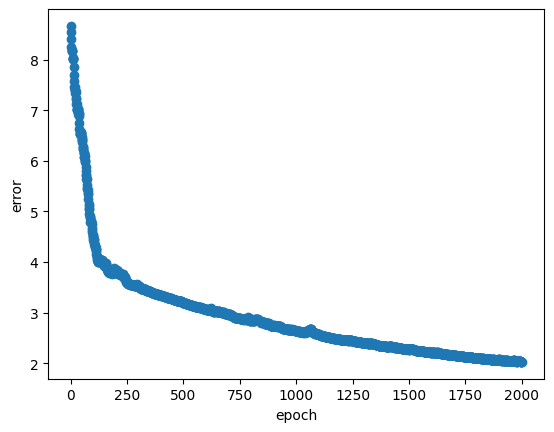

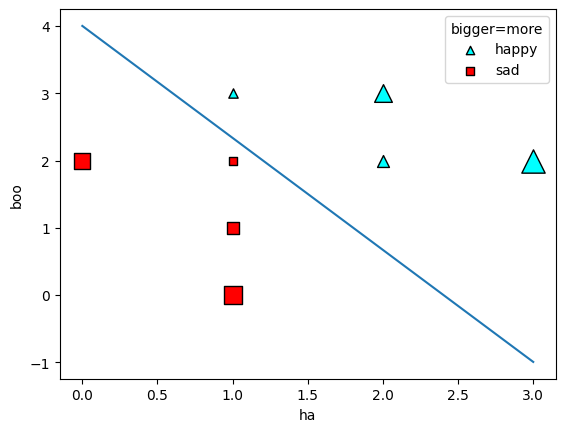

In [60]:
epochs=2000
Ws, bs, errs = logistic_regression_algorithm(batch_features, labels, learning_rate=0.01, epochs=epochs)
w = Ws[-1]
b = bs[-1]

print(f"weights={w}, bias={b}")
print(f"errors: max={max(errs)}, min={min(errs)}")

preds, losses = [], []
for i in range(len(batch_features)):
  features = batch_features[i]
  pred = prediction(w, b, features)
  loss = log_loss(w, b, features, labels[i])

  preds.append(pred)
  losses.append(loss)
# printing the dataset in table
df = pd.DataFrame({
    'Ha' : batch_features[:,0],
    'Boo' : batch_features[:,1],
    'Happy(1)/Sad(0)': labels,
    'prediction' : preds,
    'y-y_hat' : labels - preds,
    'log loss': losses
})
print(df)
print("total loss: ", sum(losses))

plt.scatter(np.arange(epochs), errs)
plt.xlabel('epoch')
plt.ylabel('error')
plt.show()

plot_logistic_points(batch_features, labels, losses, size_scale=20)
# Uncomment the following line to see a good line fit for this data.
draw_line(w[0],w[1],b)

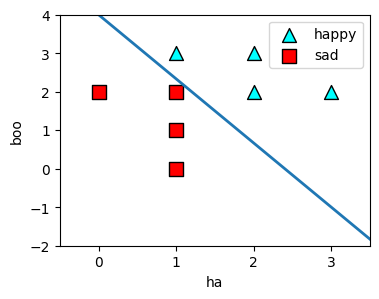

In [61]:
frames = np.linspace(0, epochs, TOTAL_FRAMES, dtype=np.uint32)
# frames, len(frames)

# check the progress of the training
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-2, 4)
plot_points(batch_features, labels, ax=ax)
line, = ax.plot([], [], lw=2)
################# animate points too #################

def init():
  line.set_data([], [])
  return line,

def update(frame):
  idx = min(epochs-1, frames[frame])
  W = Ws[idx]
  b = bs[idx]
  w1, w2 = W[0], W[1]
  x = np.linspace(0, 10, 1000)
  y = -b/w2 - w1*x/w2
  line.set_data(x, y)
  return line,

ani = FuncAnimation(fig, update, frames=TOTAL_FRAMES, init_func=init, blit=True)
HTML(ani.to_jshtml())